In [1]:
import sys
sys.path.append("../granger-busca")
import numpy as np
from bisect import bisect
import scipy.stats as ss
import matplotlib.pyplot as plt
from gb import simulate, GrangerBusca
import fit_granger_k

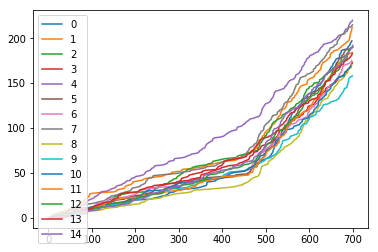

In [2]:
Alpha_t=np.array([
    [0.3,0.3],
    [0.3,0.3]
])
Alpha2_t=np.array([
    [0.8,0.1],
    [0.8,0.1]
])
Alpha_t=np.ones((15,15))*0.01
for i in range(15):
    Alpha_t[i][4]=0.04
    Alpha_t[i][0]=0.0005
Alpha2_t=np.ones((15,15))*0.06
d=len(Alpha_t)
beta=1.0
Beta_t=np.ones((d,d))*beta
mu_t = np.ones(d) *0.1


T=700
K=450
sim = simulate.GrangeBuscaSimulator(mu_t, Alpha_t,Alpha2_t,k=K)
timestamps = sim.simulate(T)

counting = [np.arange(len(timestamps[i])) for i in range(len(timestamps))]
for i in range(len(timestamps)):
    plt.plot(timestamps[i], counting[i], label='%d' % i)
plt.legend()
plt.show()

#plt.imshow(Alpha_t)
#plt.show()

#plt.imshow(Alpha2_t)
#plt.show()

In [3]:
G=G=fit_granger_k.Granger_k(timestamps,T=T)
G.fit(n_iter=400,var_k=10,var_mu=0.03,var_alpha=0.08,burn_in=200,initial_time=550)
G.print_rejection_rate()
G.plot_values()

('Accepted', 549.80727525677969)
('iteration', 0, 'time', 1.7276215553283691)
('iteration', 1, 'time', 1.698707103729248)
('iteration', 2, 'time', 1.9093279838562012)
('Accepted', 545.32117619228461)
('iteration', 3, 'time', 1.6811494827270508)
('iteration', 4, 'time', 1.6217279434204102)
('iteration', 5, 'time', 1.6400809288024902)
('Accepted', 558.65229147057971)
('iteration', 6, 'time', 1.7048072814941406)
('Accepted', 560.43238390245938)
('iteration', 7, 'time', 1.6163229942321777)
('Accepted', 569.20448410841755)
('iteration', 8, 'time', 1.5938313007354736)
('iteration', 9, 'time', 1.584505558013916)
('iteration', 10, 'time', 1.6405880451202393)
('iteration', 11, 'time', 1.5876262187957764)
('iteration', 12, 'time', 1.7071857452392578)
('Accepted', 570.92364277885963)
('iteration', 13, 'time', 1.644256353378296)
('iteration', 14, 'time', 1.700434684753418)
('Accepted', 566.86115213064431)
('iteration', 15, 'time', 1.701735496520996)
('Accepted', 572.85996710468646)
('iteration', 1

KeyboardInterrupt: 

In [5]:
def calc_delta(p1,p2,timestamps,t_idx):
    tp=timestamps[p1][t_idx]
    tpp_idx = bisect(timestamps[p2], tp)
    if tpp_idx == len(timestamps[p2]):
        tpp_idx -= 1
    tpp = timestamps[p2][tpp_idx]
    while tpp >= tp and tpp_idx > 0:
        tpp_idx -= 1
        tpp = timestamps[p2][tpp_idx]
    if tpp >= tp:
        return 0
    return tp - tpp


def P_k(k,d,T,Alpha1,Alpha2,Mu,timestamps):    
    if(k<0 or k>T):
        return float("-inf")
    
    p=0
    for p1 in range(d):
        k_idx=len(timestamps[p1]) -1 
        delta_ba=0
        past_term=[0]*d
        for t_idx in range(len(timestamps[p1])):
            first_term1=0
            second_term1=0
            first_term2=0
            second_term2=0
            
            if(timestamps[p1][t_idx]<=k):
                for p2 in range(d):
                    delta_ba=calc_delta(p1,p2,timestamps,t_idx)                
                    if(delta_ba>0):
                        first_term1+=Alpha1[p2][p1]/(1.+delta_ba)
                    
                    first_term2+=past_term[p2]*(timestamps[p1][t_idx]-timestamps[p1][t_idx-1])
                    
                    if(delta_ba>0):
                        past_term[p2]=Alpha1[p2][p1]/(1.+delta_ba)                    
                    else:
                        past_term[p2]=0.                
                        
                p+=np.log(Mu[p1]+first_term1)-first_term2
            else:
                for p2 in range(d):
                        
                    delta_ba=calc_delta(p1,p2,timestamps,t_idx)                
                    if(delta_ba>0):
                        second_term1+=Alpha2[p2][p1]/(1.+delta_ba)
                        
                    second_term2+=past_term[p2]*(timestamps[p1][t_idx]-timestamps[p1][t_idx-1])
                    
                    if(delta_ba>0):
                        past_term[p2]=Alpha2[p2][p1]/(1.+delta_ba)                    
                    else:
                        past_term[p2]=0.
                        
                p+=np.log(Mu[p1]+second_term1)-second_term2
        second_term2=0
        for p2 in range(d):
            if(t_idx>0):
                second_term2+=past_term[p2]*(T-timestamps[p1][t_idx])
    
        p-=second_term2
    return p


def P_mu(p1,k,d,T,Alpha1,Alpha2,Mu,timestamps):
    if(Mu[p1]<=0):
        return float("-inf")
    
    p=0    
    for t_idx in range(len(timestamps[p1])):
            first_term1=0
            second_term1=0
            
            if(timestamps[p1][t_idx]<=k):
                for p2 in range(d):
                    delta_ba=calc_delta(p1,p2,timestamps,t_idx)                
                    if(delta_ba>0):
                        first_term1+=Alpha1[p2][p1]/(1.+delta_ba)                   
                p+=np.log(Mu[p1]+first_term1)
            else:
                for p2 in range(d):                        
                    delta_ba=calc_delta(p1,p2,timestamps,t_idx)                
                    if(delta_ba>0):
                        second_term1+=Alpha2[p2][p1]/(1.+delta_ba)
                        
                p+=np.log(Mu[p1]+second_term1)
                
    p-=T*(Mu[p1])
    return p

def P_alpha1(p1,p2,k,d,T,Alpha1,Alpha2,Mu,timestamps):
    
    if(Alpha1[p2][p1]<0):
        return float("-inf")
    
    p=0
    k_idx=len(timestamps[p1]) -1 
    delta_ba=0
    past_term=[0]*d
    last_t_idx=0
    for t_idx in range(len(timestamps[p1])):
            first_term1=0
            first_term2=0
            if(timestamps[p1][t_idx]<=k):
                last_t_idx=t_idx
                for p2_i in range(d):
                    delta_ba=calc_delta(p1,p2_i,timestamps,t_idx)                
                    if(delta_ba>0):
                        first_term1+=Alpha1[p2_i][p1]/(1.+delta_ba)
                        #print(timestamps[p1][t_idx],p1,p2_i,Alpha1[p2_i][p1])
                    if(p2==p2_i):
                        first_term2+=past_term[p2_i]*(timestamps[p1][t_idx]-timestamps[p1][t_idx-1])
                    
                    if(delta_ba>0):
                        past_term[p2_i]=Alpha1[p2_i][p1]/(1.+delta_ba)                    
                    else:
                        past_term[p2_i]=0.  
                p+=np.log(Mu[p1]+first_term1)-first_term2
    
    first_term2=0
    
    if (last_t_idx==(len(timestamps[p1])-1)):
        final_t=T
    else:
        final_t=timestamps[p1][last_t_idx+1]
    delta_ba=calc_delta(p1,p2,timestamps,last_t_idx)       
    if(last_t_idx>0 and delta_ba>0):
        first_term2=Alpha1[p2][p1]/(1.+delta_ba)*(final_t-timestamps[p1][last_t_idx])
    p-=first_term2
    return p

def P_alpha2(p1,p2,k,d,T,Alpha1,Alpha2,Mu,timestamps):
    
    if(Alpha2[p2][p1]<0):
        return float("-inf")  
    p=0
    k_idx=len(timestamps[p1]) -1 
    delta_ba=0
    past_term=[0]*d
    for t_idx in range(len(timestamps[p1])):
            second_term1=0
            second_term2=0
            if(timestamps[p1][t_idx]>k):
                for p2_i in range(d):
                    delta_ba=calc_delta(p1,p2_i,timestamps,t_idx)                
                    if(delta_ba>0):
                        second_term1+=Alpha2[p2_i][p1]/(1.+delta_ba)
                    if(p2==p2_i):
                        second_term2+=past_term[p2_i]*(timestamps[p1][t_idx]-timestamps[p1][t_idx-1])
                    
                    if(delta_ba>0):
                        past_term[p2_i]=Alpha2[p2_i][p1]/(1.+delta_ba)   
                    else:
                        past_term[p2_i]=0.                                        
                        
                p+=np.log(Mu[p1]+second_term1)-second_term2
                    
    second_term2=0    

    if not (timestamps[p1][-1]<=k or timestamps[p1][-2]<=k):
        delta_ba=calc_delta(p1,p2,timestamps,t_idx)    
        if(t_idx>0 and delta_ba>0):
            second_term2=past_term[p2]*(T-timestamps[p1][t_idx])

    p-=second_term2
    return p
            


## Test k

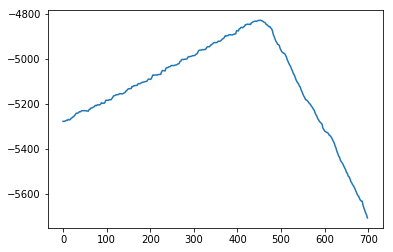

In [8]:
Alpha1=np.copy(Alpha_t)
Alpha2=np.copy(Alpha2_t)
Mu=np.copy(mu_t)
'''
k_v=[T/2]
d=len(timestamps)
past_p_k=P_k(k_v[-1],d,T,Alpha1,Alpha2,Mu,timestamps)
for i in range(400):
    new_k=ss.norm.rvs(k_v[-1],15)
    new_p_k=P_k(new_k,d,T,Alpha1,Alpha2,Mu,timestamps)
    r=np.exp(new_p_k - past_p_k)
    if(r>1 or ss.uniform.rvs()<r):
        #print("Accepted",k_v[-1],new_k,np.exp(past_p_k - new_p_k),past_p_k,new_p_k,past_p_k-new_p_k)
        k_v.append(new_k)
        past_p_k=new_p_k
    
k_v=k_v[50:]
print(len(k_v))
plt.plot(range(len(k_v)),k_v)
plt.show()

print(sum(k_v)/len(k_v))'''
l=[i*2 for i in range(0,int(T/2))]
p=[P_k(i,d,T,Alpha1,Alpha2,Mu,timestamps) for i in l]
plt.plot(l,p)
plt.show()



## Test Mu

300


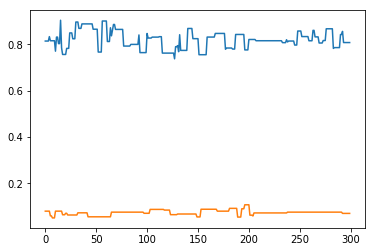

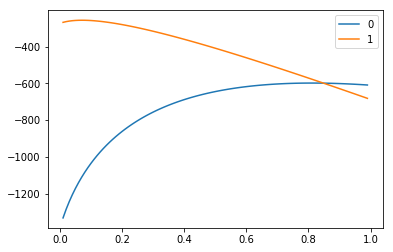

mu 0 0.819381426783
mu 1 0.073206384337


In [62]:
Alpha1=np.copy(Alpha_t)
Alpha2=np.copy(Alpha2_t)
Mu=np.copy(mu_t)
k=K

k_v=[T/2]
d=len(timestamps)
initial_value=1.0/d
Mu_v=[np.ones(shape=(d))*initial_value]
n_iter=400
for i in range(n_iter):
    new_Mu=np.copy(Mu_v[-1])
    for p1 in range(d):
        past_p_Mu=P_mu(p1,k,d,T,Alpha1,Alpha2,new_Mu,timestamps)
        new_Mu[p1]=ss.norm.rvs(Mu_v[-1][p1],scale=0.15)      
        new_p_Mu=P_mu(p1,k,d,T,Alpha1,Alpha2,new_Mu,timestamps)
        r=np.exp(new_p_Mu-past_p_Mu)
        if(r>1 or ss.uniform.rvs()<r):
            pass
            #past_p_Mu[p1]=new_p_Mu                        
        else:
            new_Mu[p1]=Mu_v[-1][p1]  

    Mu_v.append(new_Mu)


Mu_lista=[[] for i in range(2)]
burn_in=100
for i in range(d):
    for i_iter in range(burn_in,n_iter):
        Mu_lista[i].append(Mu_v[i_iter][i])
    
    
print(len(Mu_lista[0])) 
for i in range(d):
    plt.plot(range(len(Mu_lista[i])),Mu_lista[i])
plt.show()    
    
l=[i/100. for i in range(1,100)]
for i in range(d):
    Mu=np.copy(mu_t)
    p=[]
    for j in range(1,100):
        Mu[i]=j/100.
        p.append(P_mu(i,k,d,T,Alpha1,Alpha2,Mu,timestamps))
    plt.plot(l,p,label='%d' % i)
plt.legend()
plt.show()

for p1 in range(d):
    print("mu",p1,np.mean(Mu_lista[p1]))


## Test Alpha1

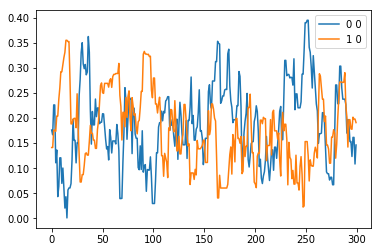

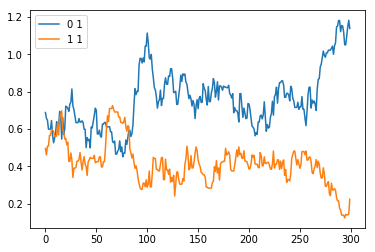

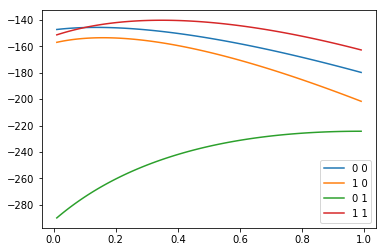

Alpha1 0 0 0.188043804807
Alpha1 0 1 0.756230069978
Alpha1 1 0 0.177872446562
Alpha1 1 1 0.418073107797


In [24]:
Alpha1=np.copy(Alpha_t)
Alpha2=np.copy(Alpha2_t)
Mu=np.copy(mu_t)
k=K

d=len(timestamps)
initial_value=1.0/d
Alpha1_v=[np.ones(shape=(d,d))*initial_value]

n_iter=400
for i in range(n_iter):
    new_Alpha1=np.copy(Alpha1_v[-1])
    for p1 in range(d):
        for p2 in range(d):
            past_p_Alpha1=P_alpha1(p1,p2,k,d,T,new_Alpha1,Alpha2,Mu,timestamps)
            new_Alpha1[p2][p1]=ss.norm.rvs(Alpha1_v[-1][p2][p1],scale=0.05)
            new_p_Alpha1=P_alpha1(p1,p2,k,d,T,new_Alpha1,Alpha2,Mu,timestamps)
            r=np.exp(new_p_Alpha1 - past_p_Alpha1)
            if(r>1 or ss.uniform.rvs()<r):
                #past_p_Alpha1[p1][p2]=new_p_Alpha1 
                pass
            else:
                new_Alpha1[p2][p1]=Alpha1_v[-1][p2][p1]
    Alpha1_v.append(new_Alpha1)
    
    
Alpha1_lista=[]
for i in range(d):
    Alpha1_lista.append([[] for i in range(d)])
    
burn_in=100
for i in range(d):
    for j in range(d):
        for i_iter in range(burn_in,n_iter):
            Alpha1_lista[i][j].append(Alpha1_v[i_iter][i][j])


for i in range(d):
    for j in range(d):
        plt.plot(range(len(Alpha1_lista[i][j])),Alpha1_lista[j][i],label='%d %d' % (j,i))
        
    plt.legend()
    plt.show()    

l=[i/100. for i in range(1,100)]
p=[]
for i in range(d):
    p.append([])
    for j in range(d):
        p[i].append([])
        Alpha1=np.copy(Alpha_t)
        for v in range(1,100):
            Alpha1[j][i]=v/100.
            p[i][j].append(P_alpha1(i,j,k,d,T,Alpha1,Alpha2,Mu,timestamps))
    
        plt.plot(l,p[i][j],label='%d %d' % (j,i))
plt.legend()
plt.show()

for p1 in range(d):
    for p2 in range(d):
        print("Alpha1",p1,p2,np.mean(Alpha1_lista[p1][p2]))


## Test Alpha2

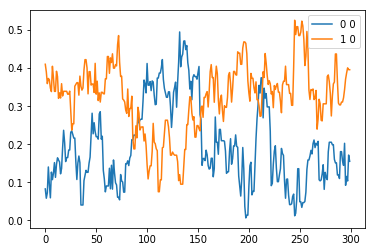

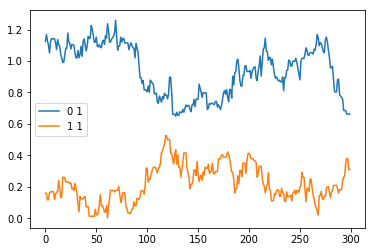

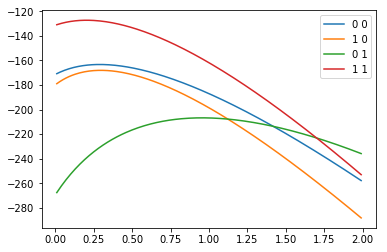

Alpha2 0 0 0.195988173317
Alpha2 0 1 0.942019981868
Alpha2 1 0 0.324093172725
Alpha2 1 1 0.221897262279


In [25]:
Alpha1=np.copy(Alpha_t)
Alpha2=np.copy(Alpha2_t)
Mu=np.copy(mu_t)
k=K

k_v=[T/2]
d=len(timestamps)
initial_value=1.0/d
Alpha2_v=[np.ones(shape=(d,d))*initial_value]

n_iter=450
for i in range(n_iter):
    new_Alpha2=np.copy(Alpha2_v[-1])
    for p1 in range(d):
        for p2 in range(d):
            past_p_Alpha2=P_alpha2(p1,p2,k,d,T,Alpha1,new_Alpha2,Mu,timestamps)
            new_Alpha2[p2][p1]=ss.norm.rvs(Alpha2_v[-1][p2][p1],scale=0.05)
            new_p_Alpha2=P_alpha2(p1,p2,k,d,T,Alpha1,new_Alpha2,Mu,timestamps)
            r=np.exp(new_p_Alpha2 - past_p_Alpha2)
            if(r>1 or ss.uniform.rvs()<r):
                #past_p_Alpha2[p1][p2]=new_p_Alpha2 
                pass
            else:
                new_Alpha2[p2][p1]=Alpha2_v[-1][p2][p1]
                
    Alpha2_v.append(new_Alpha2)
    
    
Alpha2_lista=[]
for i in range(d):
    Alpha2_lista.append([[] for i in range(2)])
    
burn_in=150
for i in range(d):
    for j in range(d):
        for i_iter in range(burn_in,n_iter):
            Alpha2_lista[i][j].append(Alpha2_v[i_iter][i][j])


for i in range(d):
    for j in range(d):
        plt.plot(range(len(Alpha2_lista[i][j])),Alpha2_lista[j][i],label='%d %d' % (j,i))
        
    plt.legend()
    plt.show()    


l=[i/100. for i in range(1,200)]
p=[]
for i in range(d):
    p.append([])
    for j in range(d):
        p[i].append([])
        Alpha2=np.copy(Alpha2_t)
        for v in range(1,200):
            Alpha2[j][i]=v/100.
            p[i][j].append(P_alpha2(i,j,k,d,T,Alpha1,Alpha2,Mu,timestamps))
    
        plt.plot(l,p[i][j],label='%d %d' % (j,i))
plt.legend()
plt.show()

for p1 in range(d):
    for p2 in range(d):
        print("Alpha2",p1,p2,np.mean(Alpha2_lista[p1][p2]))

## Everything

In [29]:
d=len(timestamps)
initial_value=1.0/d
initial_time=T/2.
k_v=[initial_time]
Mu_v=[np.ones(shape=(d))*initial_value]
Alpha1_v=[np.ones(shape=(d,d))*initial_value]
Alpha2_v=[np.ones(shape=(d,d))*initial_value]

k=k_v[0]
Mu=Mu_v[0]
Alpha1=Alpha1_v[0]
Alpha2=Alpha2_v[0]

var_k=15
var_mu=0.03
var_alpha=0.08

reject_k=0.
reject_mu=[0.]*d
reject_alpha1=[[0.]*d for i in range(d)]
reject_alpha2=[[0.]*d for i in range(d)]

n_iter=400
for i in range(n_iter):
    ######## k ########
    past_p_k=P_k(k_v[-1],d,T,Alpha1_v[-1],Alpha2_v[-1],Mu_v[-1],timestamps)
    new_k=ss.norm.rvs(k_v[-1],var_k)
    new_p_k=P_k(new_k,d,T,Alpha1_v[-1],Alpha2_v[-1],Mu_v[-1],timestamps)
    r=np.exp(new_p_k - past_p_k)
    if(r>1 or ss.uniform.rvs()<r):
        k_v.append(new_k)
        #past_p_k=new_p
    else:
        k_v.append(k_v[-1])
        reject_k+=1
    
    k=k_v[-1]
    ########  ########
    new_Mu=np.copy(Mu_v[-1])
    new_Alpha1=np.copy(Alpha1_v[-1])
    new_Alpha2=np.copy(Alpha2_v[-1])
    for p1 in range(d):
        ######## Mu ########
        past_p_Mu=P_mu(p1,k,d,T,Alpha1_v[-1],Alpha2_v[-1],new_Mu,timestamps)
        new_Mu[p1]=ss.norm.rvs(Mu_v[-1][p1],scale=var_mu)
        new_p_Mu=P_mu(p1,k,d,T,Alpha1_v[-1],Alpha2_v[-1],new_Mu,timestamps)
        r=np.exp(new_p_Mu-past_p_Mu)
        if(r>1 or ss.uniform.rvs()<r):
            #past_p_Mu[p1]=new_p_Mu
            pass
        else:
            new_Mu[p1]=Mu_v[-1][p1]
            reject_mu[p1]+=1
        ##########  ########
        
        for p2 in range(d):
            ##### Alpha1 #####
            past_p_Alpha1=P_alpha1(p1,p2,k,d,T,new_Alpha1,new_Alpha2,new_Mu,timestamps)
            new_Alpha1[p2][p1]=ss.norm.rvs(Alpha1_v[-1][p2][p1],scale=var_alpha)
            new_p_Alpha1=P_alpha1(p1,p2,k,d,T,new_Alpha1,new_Alpha2,new_Mu,timestamps)
            r=np.exp(new_p_Alpha1- past_p_Alpha1)     
            if(r>1 or ss.uniform.rvs()<r):
                #past_p_Alpha1[p1][p2]=new_p_Alpha1  
                pass
            else:
                new_Alpha1[p2][p1]=Alpha1_v[-1][p2][p1]
                reject_alpha1[p2][p1]+=1
                
            ##### Alpha2 #####
            past_p_Alpha2=P_alpha2(p1,p2,k,d,T,new_Alpha1,new_Alpha2,new_Mu,timestamps)
            new_Alpha2[p2][p1]=ss.norm.rvs(Alpha2_v[-1][p2][p1],scale=var_alpha)
            new_p_Alpha2=P_alpha2(p1,p2,k,d,T,new_Alpha1,new_Alpha2,new_Mu,timestamps)
        
            r=np.exp(new_p_Alpha2- past_p_Alpha2)
            if(r>1 or ss.uniform.rvs()<r):
                #past_p_Alpha2[p1][p2]=new_p_Alpha2
                pass
            else:
                new_Alpha2[p2][p1]=Alpha2_v[-1][p2][p1]
                reject_alpha2[p2][p1]+=1
    
    Mu_v.append(new_Mu)
    Alpha1_v.append(new_Alpha1)
    Alpha2_v.append(new_Alpha2)
    
    
burn_in=150
k_v=k_v[burn_in:]
Mu_v=Mu_v[burn_in:]
Alpha1_v=Alpha1_v[burn_in:]
Alpha2_v=Alpha2_v[burn_in:]

print("k",np.mean(k_v))
for p1 in range(d):
    print("mu",p1,np.mean([Mu_v[i][p1] for i in range(n_iter-burn_in)]))
for p1 in range(d):
    for p2 in range(d):
        print("Alpha1",p1,p2,np.mean([Alpha1_v[i][p1][p2] for i in range(n_iter-burn_in)]))
for p1 in range(d):
    for p2 in range(d):
        print("Alpha2",p1,p2,np.mean([Alpha2_v[i][p1][p2] for i in range(n_iter-burn_in)]))
        
        
print(reject_k/n_iter)
print([i/n_iter for i in reject_mu])
print([[i/n_iter for i in j] for j in reject_alpha1])
print([[i/n_iter for i in j] for j in reject_alpha2])

k 208.596915199
mu 0 0.187728153513
mu 1 0.116041950058
Alpha1 0 0 0.155217215458
Alpha1 0 1 0.621241390461
Alpha1 1 0 0.584550380276
Alpha1 1 1 0.348120844236
Alpha2 0 0 0.793943292478
Alpha2 0 1 0.214413008974
Alpha2 1 0 0.776661216839
Alpha2 1 1 0.182075210038
0.69
[0.3625, 0.495]
[[0.28, 0.205], [0.25, 0.2825]]
[[0.3625, 0.56], [0.2725, 0.4575]]


0.7325
[0.435, 0.5825, 0.5375]
[[78.0, 90.0, 104.0], [103.0, 94.0, 89.0], [87.0, 95.0, 113.0]]
[[0.195, 0.225, 0.26], [0.2575, 0.235, 0.2225], [0.2175, 0.2375, 0.2825]]
[[0.2075, 0.355, 0.33], [0.14, 0.3125, 0.285], [0.1275, 0.2125, 0.2525]]


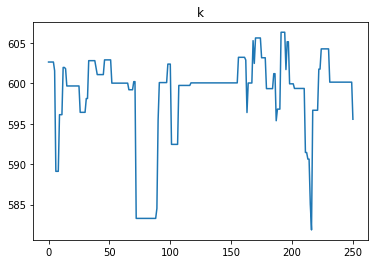

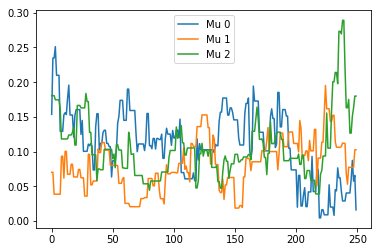

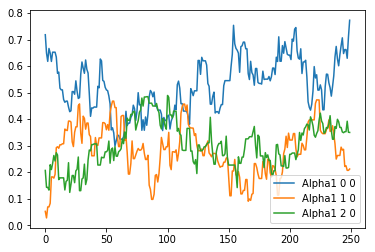

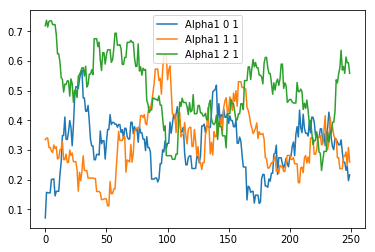

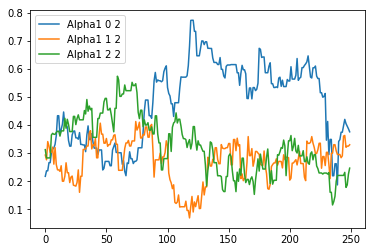

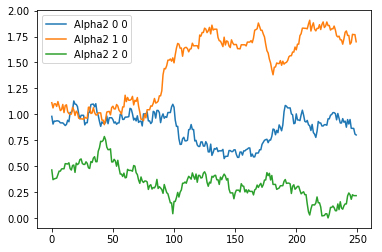

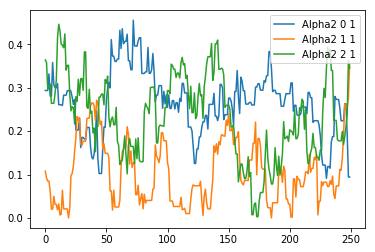

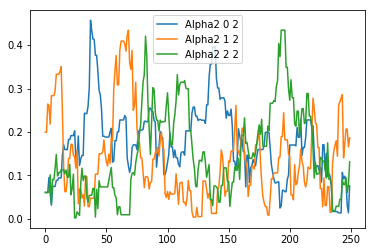

In [18]:

plt.plot(range(len(k_v)),k_v)
plt.title('k')
plt.show()

Mu_lista=[[] for i in range(d)]
for i in range(d):
    for i_iter in range(0,n_iter-burn_in):
        Mu_v[i_iter]
        Mu_lista[i].append(Mu_v[i_iter][i])
for i in range(d):
    plt.plot(range(len(Mu_lista[i])),Mu_lista[i],label='Mu '+str(i))
plt.legend()
plt.show()  

Alpha1_lista=[]
Alpha2_lista=[]
for i in range(d):
    Alpha1_lista.append([[] for i in range(d)])
    Alpha2_lista.append([[] for i in range(d)])
for i in range(d):
    for j in range(d):
        for i_iter in range(0,n_iter-burn_in):
            Alpha1_lista[i][j].append(Alpha1_v[i_iter][i][j])
            Alpha2_lista[i][j].append(Alpha2_v[i_iter][i][j])
for i in range(d):
    for j in range(d):
        plt.plot(range(len(Alpha1_lista[i][j])),Alpha1_lista[j][i],label='Alpha1 %d %d' % (j,i))
        
    plt.legend()
    plt.show()  
    
for i in range(d):
    for j in range(d):
        plt.plot(range(len(Alpha2_lista[i][j])),Alpha2_lista[j][i],label='Alpha2 %d %d' % (j,i))
        
    plt.legend()
    plt.show() 

## Sanity Test

In [12]:
timestamps=[[1,2,5],[3,4]]
alpha_t=np.array([[0.5,0.5],[0.5,0.5]])
alpha_t2=np.array([[1,1],[1,1]])
mu_t=[1,1]
T=5
k=4
d=2


print(abs(P_k(k,d,T,alpha_t,alpha_t2,mu_t,timestamps)+0.0624570818346)<0.001)
print(abs(P_mu(0,k,d,T,alpha_t,alpha_t2,mu_t,timestamps)+4.21724066075)<0.001)
alpha_new=np.copy(alpha_t)
print(abs(P_alpha1(0,0,k,d,T,alpha_t,alpha_t2,mu_t,timestamps)+0.526856448686)<0.001)
alpha_new=np.copy(alpha_t2)
print(abs(P_alpha2(0,0,k,d,T,alpha_t,alpha_t2,mu_t,timestamps)-0.55961578793542266)<0.001)



True
True
True
True
